In [1]:
# 对 GPTV.py 中的 GPTModel 类进行训练，训练数据是 the-verdict.txt
# 包括两个部分
# 第一部分，数据处理，将 the-verdict.txt 中的文本转换为训练和测试两个数据集
# 第二部分，模型训练，使用训练数据集训练模型，并实时跟踪在测试集上的效果

import torch
#
from GPTV1 import GPTModel
import tiktoken
import os


In [ ]:


GPT_CONFIG_124M = {
"vocab_size" : 100277,
"context_length" : 256,
"emb_dim" : 768,
"n_heads" : 12,
"n_layers" : 12,
"drop_rate" : 0.1,
"qkv_bias" : False
}

BATCH_SIZE = 16
EPOCHS = 3

# GPT_CONFIG_124M = {
#     "vocab_size": 50257,     # Vocabulary size
#     "context_length": 1024,  # Context length
#     "emb_dim": 768,          # Embedding dimension
#     "n_heads": 12,           # Number of attention heads
#     "n_layers": 12,          # Number of layers
#     "drop_rate": 0.1,        # Dropout rate
#     "qkv_bias": False        # Query-Key-Value bias
# }


# # 数据处理
# # 加载数据文件，the-verdict.txt
# with open("./LLM/the-verdict.txt", "r") as f:
#     data = f.read()
# print(data[:100])


# 加载四个txt文件的数据作为训练数据，./data/12.txt, ./data/3.txt, ./data/108.txt, ./data/4.txt
# 每个文件中的数据量为 1000 条
# 每个文件中的数据量为 1000 条
with open("./data/12.txt", "r") as f:
    data12 = f.read()
# with open("./data/3.txt", "r") as f:
#     data3 = f.read()
# with open("./data/108.txt", "r") as f:
#     data108 = f.read()
# with open("./data/4.txt", "r") as f:
#     data4 = f.read()

# 合并四个文件的数据
data = data12 #+ data3 + data108 + data4 


# 将数据转换为 tokens
tokenizer = tiktoken.get_encoding("cl100k_base")
# 词典大小
print(tokenizer.n_vocab)
#GPT_CONFIG_124M["vocab_size"] = tokenizer.n_vocab

#tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode(data)
print(tokens[:100])
print(len(tokens))



# 以一个具体例子直观测试模型表现
# 从文件 the-verdict.txt中取一段
# I looked about the spacious white-panelled room, with its _famille-verte_ vases repeating the tones of the pale damask curtains, and its eighteenth-century pastels in delicate faded frames.
# 让模型续写“I looked about the spacious”
sample_tokens = tokenizer.encode("林黛玉抓住宝玉的手说") 
print("sample_tokens: ", sample_tokens) 


# 封装dataset 和dataloader,每个样本的max_len为 256，batch_size 为 2
# 比如第一个样本为，0-255 个 token，其对应的标签为 1-256 个 token，以此类推
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, tokens, max_len, stride):
        self.tokens = tokens
        self.max_len = max_len
        self.stride = stride

    def __len__(self):
        return (len(self.tokens) - self.max_len) // self.stride + 1 # 每个样本的长度为 max_len，每个样本之间的步长为 stride

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.max_len
        input_ids = self.tokens[start:end]
        label_ids = self.tokens[start+1:end+1]
        return torch.tensor(input_ids), torch.tensor(label_ids)

# check dataset and dataloader
# 默认按照context_length进行切分
max_len = GPT_CONFIG_124M["context_length"]
stride = max_len # 每个样本之间的步长为 128，即每个样本的 token 数量为 256，每个样本的标签 token 数量为 255
# 如果stride=max_len，那么每个样本之间就没有重叠，每个样本都是独立的
# 如果stride<max_len，那么每个样本之间就会有重叠，每个样本的 token 数量会小于 max_len

train_tokens = tokens[:int(0.9*len(tokens))]
test_tokens = tokens[int(0.9*len(tokens)):] # 测试数据集使用最后 10% 的 token

print(len(train_tokens))
print(len(test_tokens))

train_dataset = GPTDatasetV1(train_tokens, max_len, stride)
test_dataset = GPTDatasetV1(test_tokens, max_len, stride)

print("训练数据集样本数量: ", len(train_dataset))
print("测试数据集样本数量: ", len(test_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# for batch in train_dataloader:
#     input_ids, label_ids = batch
#     print("input_ids shape, label_ids shape: ", input_ids.shape, label_ids.shape)

# 训练过程分多个 epoch, 每个 epoch 训练完所有的样本, 每个 epoch 结束后, 用测试数据集评估模型效果
# 每个 epoch 中包含多个 batch，针对每个 batch 进行前向传播、计算损失、反向传播、更新参数
# 每个 batch 训练完成后，用测试数据集评估模型效果

# 初始化记录训练过程和训练效果的变量
train_losses = []
test_losses = []

# 定时将训练损失和测试损失记录下来，用于后续可视化分析


100277
[271, 17905, 11239, 115, 51431, 15120, 18904, 220, 220, 7518, 226, 45826, 104, 37795, 238, 162, 95, 99, 7190, 119, 6744, 228, 33035, 66285, 113, 23249, 13647, 122, 25132, 101, 14276, 239, 72406, 236, 16175, 246, 17486, 222, 13357, 118, 14191, 222, 271, 220, 73028, 97, 30867, 11239, 115, 30537, 15120, 18904, 75863, 59983, 58521, 37026, 6823, 239, 5232, 63212, 27552, 122, 82302, 39282, 15120, 87217, 162, 95, 99, 7190, 119, 55030, 34547, 3922, 8067, 227, 45163, 89151, 30926, 37795, 238, 86436, 3922, 69636, 20022, 253, 1, 33035, 66285, 113, 1, 55030, 37687, 3922, 58843, 108, 33091, 28038, 163, 59815]
1190621
sample_tokens:  [20119, 245, 30868, 249, 29207, 231, 24326, 241, 8687, 237, 8676, 251, 29207, 231, 9554, 46034, 37687]
1071558
119063
训练数据集样本数量:  4185
测试数据集样本数量:  465
['model_epoch_2.pt', 'model_epoch_1.pt', 'model_epoch_0.pt']
Loaded model from ./model_epoch_2.pt
Start training from epoch 2
Total number of parameters: 232163328


In [ ]:

#import必要的包
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import os


# 加载模型，设置必要的环境和参数
device = torch.device("mps")




model = GPTModel(GPT_CONFIG_124M)

# 检查是否存在checkpoint文件，如 model_epoch_11.pt
# 读取当前目录下所有的 checkpoint 文件
checkpoint_path = "./"
checkpoint_files = [f for f in os.listdir(checkpoint_path) if f.startswith("model_epoch_") and f.endswith(".pt")]
print(checkpoint_files)
# 找到最新的 checkpoint 文件
latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split("_")[-1].split(".")[0])) # 找到最新的 checkpoint 文件，根据 epoch 序号排序
checkpoint_path = checkpoint_path + latest_checkpoint
epoch_str = checkpoint_path.split("_")[-1].split(".")[0]
start_epoch = int(epoch_str)

# 加载模型参数
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded model from {checkpoint_path}")

# 读取 epoch 的序号，从文件名中提取
# 从文件名中提取 epoch 序号
epoch_str = checkpoint_path.split("_")[-1].split(".")[0]
start_epoch = int(epoch_str)
print(f"Start training from epoch {start_epoch}")



# 统计模型参数数量
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

model.to(device)

# 初始化优化器和学习率调度器
#optimizer = optim.Adam(model.parameters(), lr=0.0004, weight_decay=0.1)
# 使用 adamw 优化器
optimizer = optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)    
#scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.988 ** epoch) # 学习率衰减策略，每个 epoch 学习率衰减为原来的 98%



In [ ]:
# 用模型在输入上连续生成50个字
def generate_text(model, sample_tokens, max_new_tokens=100):
    model.eval() # 切换到评估模式
    #copy sample_tokens to avoid modifying the original list
    sample_tokens = sample_tokens.copy()

    with torch.no_grad(): # 关闭梯度计算
        for _ in range(max_new_tokens):
            input_ids = torch.tensor([sample_tokens]).to(device) # 输入测试数据集
            sample_output = model(input_ids) # 生成 1 个新 token, output shape: (1, seq_len, vocab_size)

            # 取输出中最后一个 token 的 logits
            sample_logits = sample_output[0, -1, :] # 取输出中最后一个 token 的 logits, 形状为 (vocab_size,)
            # # 取 logits 中最大的那个 token 作为生成的 token
            # new_token = torch.argmax(sample_logits, dim=-1).item()

            # 不是直接选择最大值对应的 token id，
            # 使用 top-k算法
            # 取 logits 中最大的 k 个 token 作为生成的 token
            k = 3
            top_k_logits, top_k_indices = torch.topk(sample_logits, k=k) # logits是具体的值，indices 是对应的位置
            # 从 top k 个 token 中随机采样一个作为生成的 token
            # 不是简单的随机的，要考虑top-k中每个token的概率, 概率越高，被选中的概率就越大
            # 计算每个 token 被选中的概率
            probs = torch.softmax(top_k_logits, dim=-1)
            
            # 从 top k 个 token 中随机采样一个作为生成的 token
            new_token = torch.multinomial(probs, num_samples=1).item()
            # 获取对应的原始 位置 Id
            new_token = top_k_indices[new_token].item() # 从 top k 个 token 中随机采样一个作为生成的 token

            sample_tokens.append(new_token) # 将生成的 token 加入到输入中    
    return sample_tokens  

In [ ]:

sample_tokens = tokenizer.encode("你好")
print("sample_tokens: ", sample_tokens)
#验证模型在sample_tokens上的表现
model.eval() # 切换到评估模式
with torch.no_grad(): # 关闭梯度计算
    output = generate_text(model, sample_tokens, max_new_tokens=100) 
    print("output tokens: ", len(output))
    print("generated text: ", tokenizer.decode(output)) 

Epoch 3
Batch 1
train loss:  2.5602993965148926
test loss:  3.217411176363627
Batch 2
train loss:  2.390638828277588
test loss:  3.2245121955871583
Batch 3
train loss:  2.5045166015625
test loss:  3.233021132151286
Batch 4
train loss:  2.4330620765686035
test loss:  3.2358378489812214
Batch 5
train loss:  2.7783761024475098
test loss:  3.2277239561080933
Batch 6
train loss:  2.599982738494873
test loss:  3.2198904514312745
Batch 7
train loss:  2.6561965942382812
test loss:  3.220629111925761
Batch 8
train loss:  2.717263698577881
test loss:  3.222316869099935
Batch 9
train loss:  2.708259105682373
test loss:  3.222512729962667
Batch 10
train loss:  2.6433258056640625
test loss:  3.225003735224406
Batch 11
train loss:  2.8331809043884277
test loss:  3.222511132558187
Batch 12
train loss:  2.5084707736968994
test loss:  3.224675496419271
Batch 13
train loss:  2.4547603130340576
test loss:  3.2225073178609214
Batch 14
train loss:  2.715313196182251
test loss:  3.2238702217737836
Batch 15


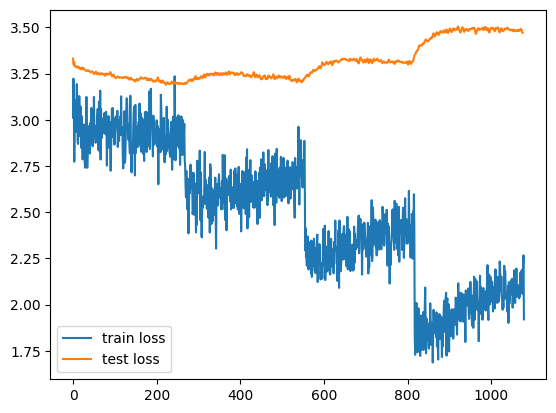

In [7]:
# 从 start_epoch+1 开始训练
next_epoch = start_epoch + 1
for epoch in range(next_epoch, next_epoch + EPOCHS):
    print(f"Epoch {epoch}")
     # 每个 epoch 中包含多个 batch，针对每个 batch 进行前向传播、计算损失、反向传播、更新参数
    batch_count = 0
    for batch in train_dataloader:
        batch_count += 1
        print(f"Batch {batch_count}")


        # 每个 batch 训练前，先将模型切换到训练模式
        model.train()

        optimizer.zero_grad() # 清空之前的梯度


        # 前向传播
        input_ids, label_ids = batch
        input_ids, label_ids = input_ids.to(device), label_ids.to(device) # 将输入和标签移动到 GPU 上
        # the shape of input_ids: (batch_size, seq_len)
        # the shape of label_ids: (batch_size, seq_len)
        # input_ids和label_ids都是 2*256，如果 batch 是 2 的话，256 里面是每个 token 的 id，就是在字典里面的位置
        output = model(input_ids) # 前向传播，得到模型的输出
        # the shape of output: (batch_size, seq_len, vocab_size)
        # output里面是已经变成将模型维度的向量转换为 vocab size 维的向量，每个元素是一个 vocab_size 维的向量，每个元素是一个 token id 的概率分布
        # 训练的目标就是要这个vocab size 维的向量尽量与 one-hot 一致，也就是每个元素的概率分布与 label_ids 中对应的 token id 一致
        # 因为使用了 Causal Attention，输出中的每个位置的vocab size 维的向量都应该和 label_ids 中对应的 token id 一致
        # 以 batch_size=2, seq_len=256 为例，output 是一个 2*256*100277 的张量，每个元素是一个 vocab_size 维的向量，每个元素是一个 token id 的概率分布
        # label_ids 是一个 2*256 的张量，每个元素是一个 token id
        # 要计算损失，需要将 output 和 label_ids 展平为一维向量
        # 先将 output 展平为二维，第一维为 batch_size * seq_len，第二维为 vocab_size
        # 再将 label_ids 展平为一维，长度为 batch_size * seq_len
        # 然后两者就可以对起来，每个位置的 vocab size 维的向量和 label_ids 中对应的 token id 就可以计算损失了
        # 每个位置的损失是一个标量，代表这个位置的 token id 的预测概率与真实 token id 的差异
        # 对所有位置的损失取平均，就得到了这个 batch 的损失
        
        ## 直观检验
        # #将output转换为具体的文字，与label_ids对比
        # predicted_ids = torch.argmax(output, dim=-1) # 取每个位置上概率最大的 token id，得到形状为 (batch_size, seq_len) 的张量
        # # 对 predicted_ids 进行 decode，将 predicted_ids 转换为具体一行文字
        # predicted_texts = tokenizer.decode_batch(predicted_ids.tolist()) # 得到一个列表，每个元素是一个字符串，代表一个样本的预测文字
        # print("predicted_texts: ", predicted_texts)
        # # 打印label_ids对应的一行文字
        # label_texts = tokenizer.decode_batch(label_ids.tolist()) # 得到一个列表，每个元素是一个字符串，代表一个样本的真实文字
        # print("label_texts: ", label_texts)
        
        # 计算损失
        loss = torch.nn.functional.cross_entropy(output.view(-1, output.size(-1)), label_ids.view(-1)) 
        # 计算损失，注意要将输出和标签展平为一维向量, 
        # output.view(-1, output.size(-1)) 表示将输出张量展平为二维，第一维为 batch_size * seq_len，第二维为 vocab_size
        # label_ids.view(-1) 表示将标签张量展平为一维，长度为 batch_size * seq_len

        print("train loss: ", loss.item())
        train_losses.append(loss.item()) # 记录训练损失


        # 反向传播和参数更新        
        loss.backward() # 计算当前 batch 的梯度
        optimizer.step() # 更新模型参数 
        #scheduler.step() # 更新学习率
        #new learning rate
        #print("new learning rate: ", scheduler.get_last_lr()[0])   


        # 每个 batch 训练完成后，用测试数据集评估模型效果
        model.eval() # 切换到评估模式
        with torch.no_grad(): # 关闭梯度计算
            batch_test_losses = []
            for batch in test_dataloader:
                input_ids, label_ids = batch 
                input_ids, label_ids = input_ids.to(device), label_ids.to(device) # 将输入和标签移动到 GPU 上
                output = model(input_ids) # 前向传播，得到模型的输出 ，output shape: (batch_size, seq_len, vocab_size)
                #output.view(-1, output.size(-1))，把 batch_size 和 seq_len 合并起来，变成一个一维向量，每个元素是一个 vocab_size 维的向量
                #label_ids.view(-1)，把 batch_size 和 seq_len 合并起来，变成一个一维向量，每个元素是一个 token id
                loss = torch.nn.functional.cross_entropy(output.view(-1, output.size(-1)), label_ids.view(-1)) # 计算损失，loss 是一个标量

                batch_test_losses.append(loss.item()) # 记录测试损失
        #记录这个 batch 的平均损失
        test_losses.append(sum(batch_test_losses) / len(batch_test_losses)) # 记录测试损失
        print("test loss: ", test_losses[-1])   
        
        # # 检查 loss，如果 loss 小于 1.5，说明模型已经收敛，提前结束训练
        # if loss.item() < 1.5:
        #     # 保存模型到 checkpoint 文件夹，文件名格式为 model_epoch_{epoch}.pt
        #     # 检查是否已经存在 model_epoch_{epoch}.pt 文件
        #     if os.path.exists(f"model_epoch_{epoch}.pt"):
        #         # 如果已经存在，提示用户是否覆盖
        #         confirm = input(f"model_epoch_{epoch}.pt already exists, do you want to overwrite it? (y/n) ")
        #         if confirm.lower() != "y":
        #             # 如果用户不确认，跳过保存
        #             continue
        #     torch.save(model.state_dict(), f"model_epoch_{epoch}.pt")
        #     print("loss is less than 1.5, stop training")
        #     break
        
    # 每个 epoch 训练完成后，打印训练损失和测试损失
    #print(f"train loss: {train_losses[-1]:.4f}, test loss: {test_losses[-1]:.4f}")
    
    #验证模型在sample_tokens上的表现
    model.eval() # 切换到评估模式
    with torch.no_grad(): # 关闭梯度计算
        output = generate_text(model, sample_tokens, max_new_tokens=100) 
        print("output tokens: ", len(output))
        print("generated text: ", tokenizer.decode(output)) 

    # 每个 epoch 训练完成后，保存模型到 checkpoint 文件夹，文件名格式为 model_epoch_{epoch}.pt
    torch.save(model.state_dict(), f"model_epoch_{epoch}.pt")

#展示整个训练过程中，train loss，以及test loss的变化趋势
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()




In [15]:
sample_tokens = tokenizer.encode("荣府的门前有个小童")

#测试多个
samples = ["荣府的门前有个小童", "宝玉握着一个小苹果", "林黛玉在房间里","贾琏插了进去"]

#验证模型在sample_tokens上的表现
model.eval() # 切换到评估模式
with torch.no_grad(): # 关闭梯度计算
   for sample in samples:
       sample_tokens = tokenizer.encode(sample)
       output = generate_text(model, sample_tokens, max_new_tokens=100) 
       print("output tokens: ", len(output))
       print("generated text: ", tokenizer.decode(output)) 


output tokens:  112
generated text:  荣府的门前有个小童拿着，    所那边的小丫头拿着一件半点的，也有拿的小丫头，也有半天的．这也有一个的，    所以为这些丫头们的也有八头的，只有这些丫头的丫头都是些的，也有说是那些书的，有这一包
output tokens:  113
generated text:  宝玉握着一个小苹果品，拿着钱来拍手，拿着一件半碗池花，    看玉钏儿也哄着一声，抿着眼泪抿着，手抿着脚的一般．一时骂道：“好狠儿，你烧的狠的打着
output tokens:  111
generated text:  林黛玉在房间里拿着钓竿钓髂，    太见黛玉辉手上，躺着眼睛，眼看着眼睛睛直流泪，黛玉钓的钓．宝玉道：“你别动了，别动那鬼淫了．    我也不是这么话。”黛玉点
output tokens:  109
generated text:  贾琏插了进去，只见凤姐便笑道：“你们只管放在眼里，我也不敢去，我还不敢叫我去．你们不管家，我也不要随便，你们就不依了，我就不依我。”    


　　凤姐儿听了，不防下泣，一声笑道：“你们听见，�
